<a href="https://colab.research.google.com/github/FarzanehMeshkinghalam/FarzanehMeshkin/blob/main/Demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we will import the necessary Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import  r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import files

In [ ]:
uploaded= files.upload()

Saving fulfilment_center_info.csv to fulfilment_center_info.csv
Saving meal_info.csv to meal_info.csv
Saving train.csv to train.csv


**We have 3 CSV files that we will read and merge all of them**

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
meal= pd.read_csv('meal_info.csv')

In [ ]:
ful=pd.read_csv('fulfilment_center_info.csv')

In [ ]:
#I merged the columns from all of the datasets to see if there is additional information that can help the model more accurately
df=df.merge(meal,on='meal_id')

In [ ]:
df=df.merge(ful,on='center_id')

In [ ]:
df.tail()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
456543,1437396,141,61,2104,583.03,630.53,0,1,13,Fish,Continental,473,77,TYPE_A,4.5
456544,1060716,142,61,2104,581.03,582.03,0,0,42,Fish,Continental,473,77,TYPE_A,4.5
456545,1029231,143,61,2104,583.03,581.03,0,0,40,Fish,Continental,473,77,TYPE_A,4.5
456546,1141147,144,61,2104,582.03,581.03,0,0,53,Fish,Continental,473,77,TYPE_A,4.5
456547,1443704,145,61,2104,581.03,582.03,0,0,27,Fish,Continental,473,77,TYPE_A,4.5


In [ ]:
df[['base_price','num_orders']].describe()

,base_price,num_orders
count,456548.000000,456548.000000
mean,354.156627,261.872760
std,160.715914,395.922798
min,55.350000,13.000000
25%,243.500000,54.000000
50%,310.460000,136.000000
75%,458.870000,324.000000
max,866.270000,24299.000000


# ** Data Preaparation **

Handelling missing values

In [ ]:
#  missing value
df.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

# EDA for Meal Delivery Forecasting

<ipython-input-50-7621e67c407e>:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  g = sns.displot(data=df, x='category', hue='cuisine', height=6, aspect=2, multiple='stack', palette=custom_colors)


<Figure size 1500x1500 with 0 Axes>

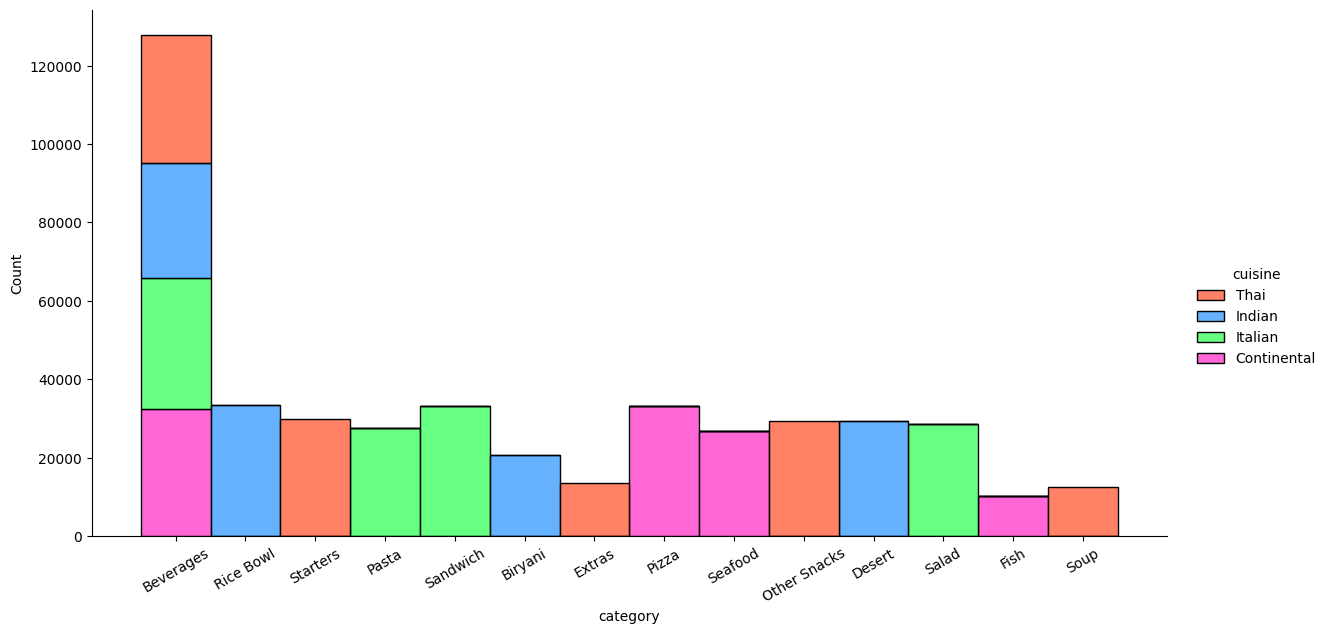

In [50]:
# creating a stacked bar plot to visualize the distribution of categories based on different cuisines in the DataFrame

# Defining a custom list of colors
custom_colors = ["#FF5733", "#3399FF", "#33FF57", "#FF33C9", "#33B4FF"]

fig = plt.figure(figsize=(15, 15))

g = sns.displot(data=df, x='category', hue='cuisine', height=6, aspect=2, multiple='stack', palette=custom_colors)
g.set_xticklabels(rotation=30)
plt.show()


<ipython-input-53-4373382ea22a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


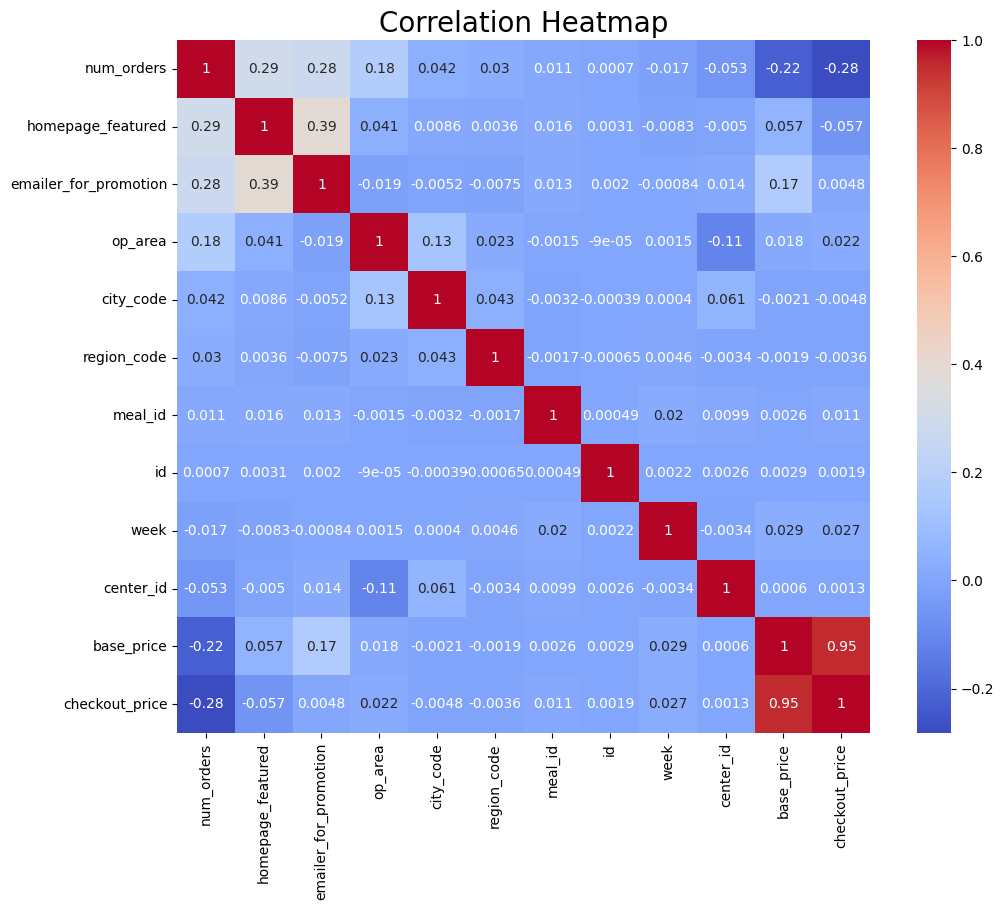

In [53]:
# creating a heat map to visualize the Correlation Between 'num_orders' and other Features
# Computing the correlation matrix
correlation_matrix = df.corr()

# Sorting the correlations in descending order
correlation_matrix['num_orders'].sort_values(ascending=False)
corr_num = 18
corr_col = correlation_matrix.nlargest(corr_num, 'num_orders')['num_orders'].index
corr_sales = np.corrcoef(df[corr_col].values.T)

# customize the colors
f, ax = plt.subplots(figsize=(12, 9))
custom_cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr_sales, annot=True, cmap=custom_cmap, yticklabels=corr_col.values, xticklabels=corr_col.values, square=True)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()


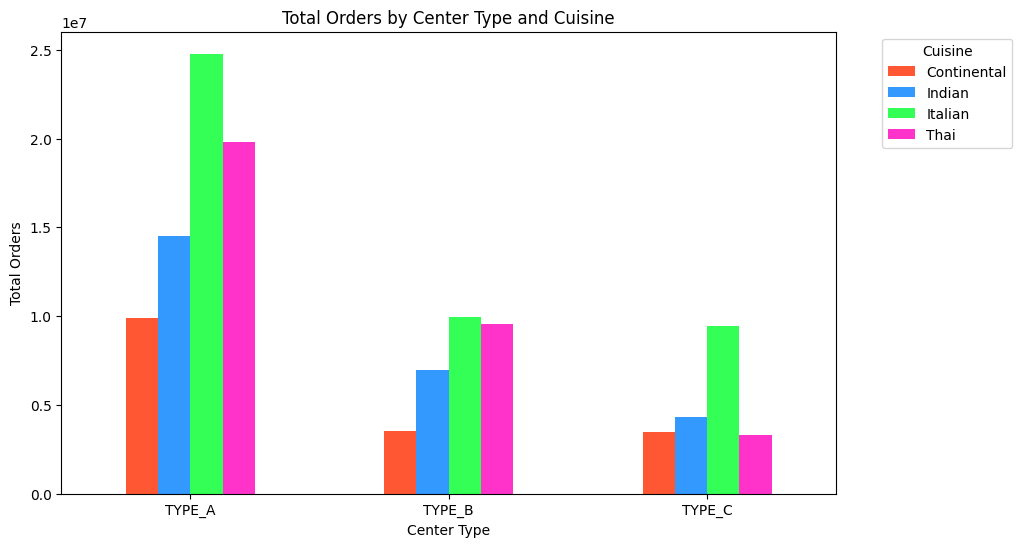

In [51]:
# Grouping and pivoting data
a = df.groupby(['center_type', 'cuisine'])['num_orders'].sum()
a = a.unstack().fillna(0)

# Defining a custom list of colors
custom_colors = ["#FF5733", "#3399FF", "#33FF57", "#FF33C9", "#33B4FF"]

# Creating the bar plot with custom colors
a.plot(kind='bar', color=custom_colors, figsize=(10, 6))

plt.xlabel('Center Type')
plt.ylabel('Total Orders')
plt.title('Total Orders by Center Type and Cuisine')
plt.xticks(rotation=0)
plt.legend(title='Cuisine', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
region = df.groupby(['region_code'])[['num_orders']].sum()
region

,num_orders
region_code,
23,1609906
34,24051733
35,691044
56,60520191
71,2103282
77,20529653
85,8685386
93,1366290


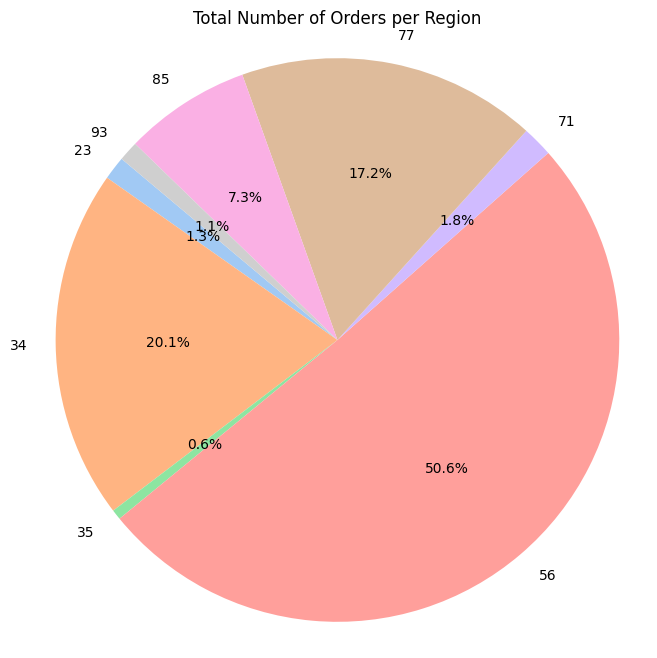

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(region['num_orders'], labels=region.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Total Number of Orders per Region')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

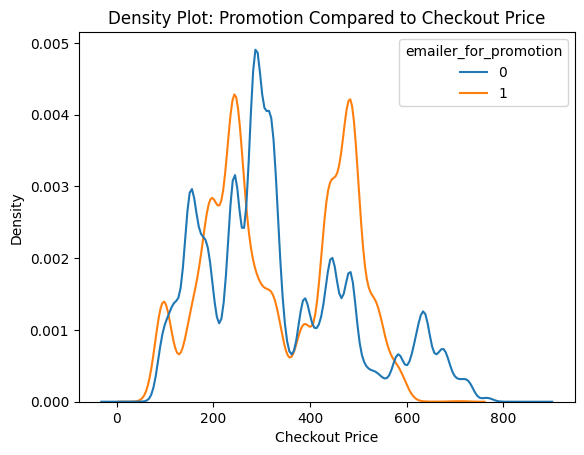

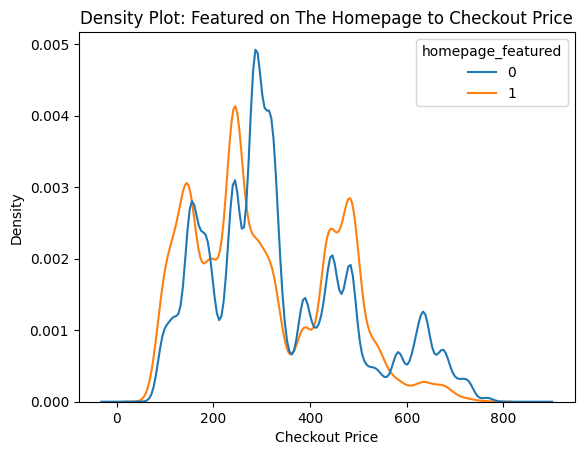

In [ ]:
plt.clf()
sns.kdeplot(data=df, x='checkout_price', hue='emailer_for_promotion', common_norm=False)
plt.title('Density Plot: Promotion Compared to Checkout Price')
plt.xlabel('Checkout Price')
plt.ylabel('Density')
plt.show()

plt.clf()
sns.kdeplot(data=df, x='checkout_price', hue='homepage_featured', common_norm=False)
plt.title('Density Plot: Featured on The Homepage to Checkout Price')
plt.xlabel('Checkout Price')
plt.ylabel('Density')
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   category               456548 non-null  object 
 10  cuisine                456548 non-null  object 
 11  city_code              456548 non-null  int64  
 12  region_code            456548 non-null  int64  
 13  center_type            456548 non-null  object 
 14  op_area                456548 non-nu

In [ ]:
top6 = df.groupby('category').num_orders.sum()
top6_sorted = top6.sort_values(ascending=False)
print(top6_sorted)

category
Beverages       40480525
Rice Bowl       20874063
Sandwich        17636782
Salad           10944336
Pizza            7383720
Other Snacks     4766293
Starters         4649122
Extras           3984979
Seafood          2715714
Desert           1940754
Pasta            1637744
Soup             1039646
Fish              871959
Biryani           631848
Name: num_orders, dtype: int64


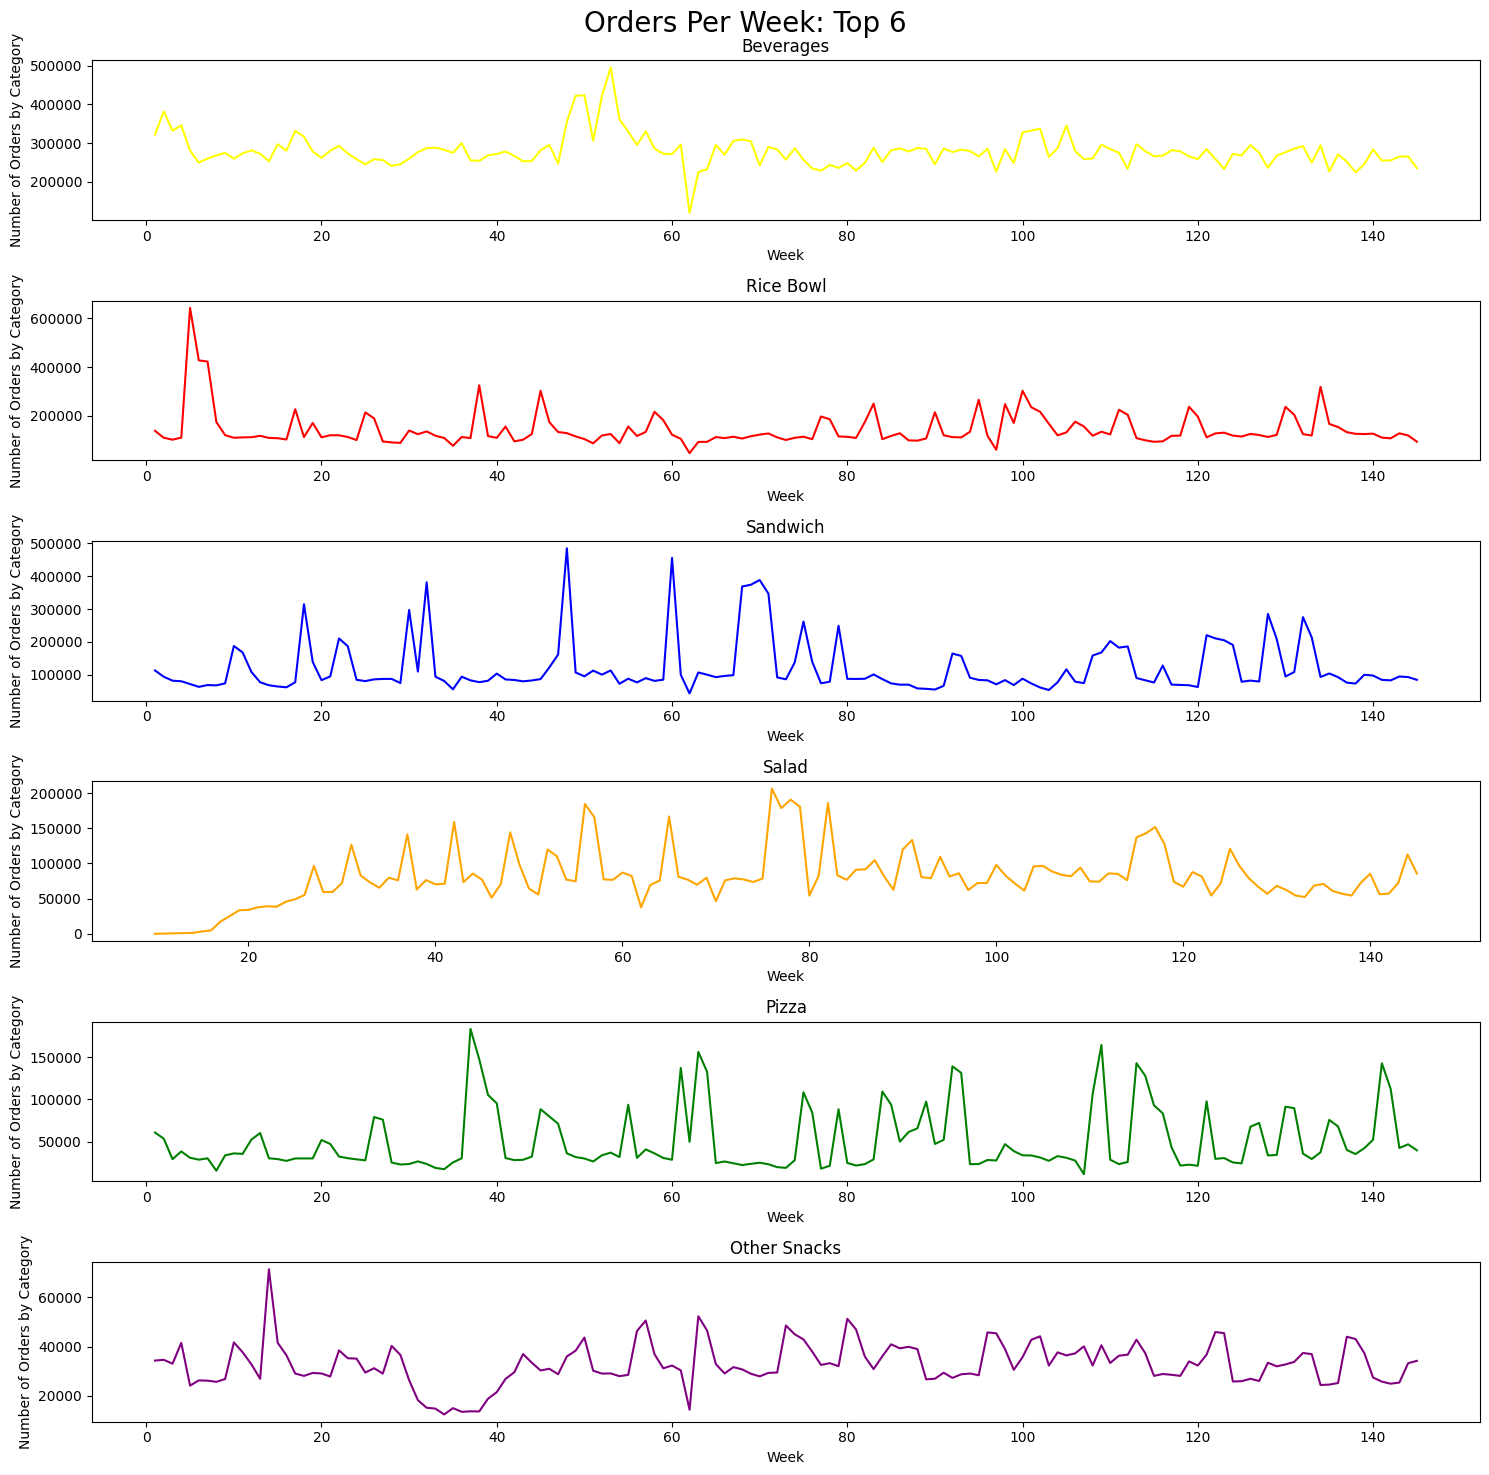

In [ ]:
fig, (ax1, ax2, ax3,ax4, ax5,ax6) = plt.subplots(6, figsize = (15,15))
top6 = ['Beverages', 'Rice Bowl', 'Sandwich', 'Salad', 'Pizza', 'Other Snacks']
color = ['yellow', 'red', 'blue', 'orange','green', 'purple']
subs = [ax1,ax2,ax3,ax4,ax5,ax6]
for typ, sub, col in zip(top6, subs, color):
    weekwise = df[df['category'] == typ].groupby('week').num_orders.sum()
    sub.plot(weekwise, color = col)
    sub.set_title(typ)
    sub.set_xlabel('Week')
    sub.set_ylabel('Number of Orders by Category')

fig.suptitle('Orders Per Week: Top 6', fontsize = 20)
fig.subplots_adjust(top=0.90)
plt.xlabel('Week')
fig.tight_layout()
plt.show()

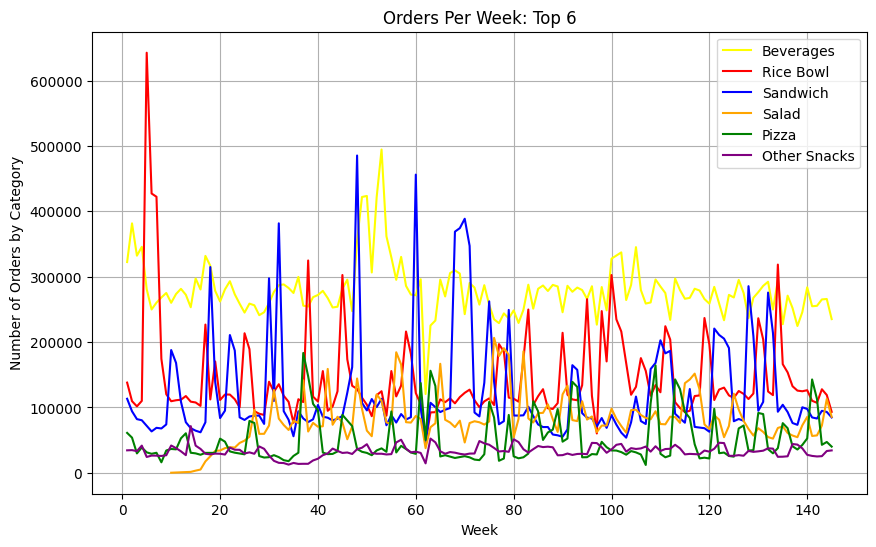

In [ ]:
import matplotlib.pyplot as plt

top6 = ['Beverages', 'Rice Bowl', 'Sandwich', 'Salad', 'Pizza', 'Other Snacks']
colors = ['yellow', 'red', 'blue', 'orange', 'green', 'purple']

plt.figure(figsize=(10, 6))

for i in range(len(top6)):
    typ = top6[i]
    col = colors[i]
    weekwise = df[df['category'] == typ].groupby('week').num_orders.sum()
    plt.plot(weekwise, label=typ, color=col)

plt.title('Orders Per Week: Top 6')
plt.xlabel('Week')
plt.ylabel('Number of Orders by Category')
plt.legend()
plt.grid()
plt.show()

Epoch 1/50
1656/1656 [==============================] - 19s 9ms/step - loss: 224.7193
Epoch 2/50
1656/1656 [==============================] - 13s 8ms/step - loss: 202.7650
Epoch 3/50
1656/1656 [==============================] - 14s 8ms/step - loss: 158.8064
Epoch 4/50
1656/1656 [==============================] - 13s 8ms/step - loss: 138.1157
Epoch 5/50
1656/1656 [==============================] - 13s 8ms/step - loss: 126.2197
Epoch 6/50
1656/1656 [==============================] - 13s 8ms/step - loss: 118.2627
Epoch 7/50
1656/1656 [==============================] - 12s 7ms/step - loss: 112.5352
Epoch 8/50
1656/1656 [==============================] - 12s 7ms/step - loss: 108.4227
Epoch 9/50
1656/1656 [==============================] - 13s 8ms/step - loss: 105.1369
Epoch 10/50
1656/1656 [==============================] - 12s 7ms/step - loss: 102.7695
Epoch 11/50
1656/1656 [==============================] - 12s 8ms/step - loss: 100.5775
Epoch 12/50
1656/1656 [=============================

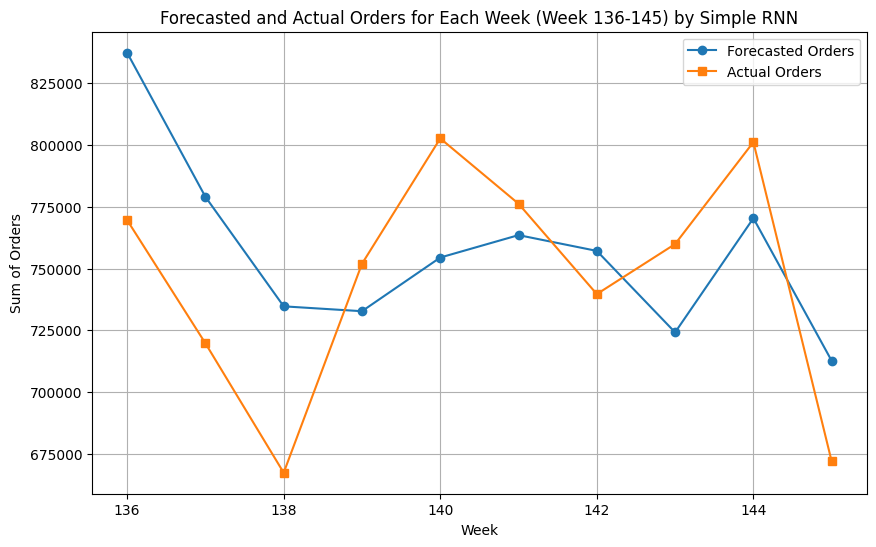

Mean Absolute Error: 54.30341632108809
Mean Squared Error: 9655.269218936886
Root Mean Squared Error: 98.2612294800797
Mean Absolute Percentage Error: 48.3917650548311
R-squared: 0.8737940292503782


In [ ]:
#Simple RNN 2 layers(128,64) epochs =50  batch size= 256 ==>MAE = 54.30
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



lag_range = range(10, 15)

df_lag = df.copy()

for lag in lag_range:
    span = lag
    ewma_column = f'num_orders_ewma_{lag}'
    df_lag[ewma_column] = df['num_orders'].ewm(span=span, adjust=False).mean()

# Label encode categorical columns
label_encoder = LabelEncoder()
for col in ['category', 'cuisine', 'center_type']:
    df_lag[col] = label_encoder.fit_transform(df_lag[col])

X = df_lag.drop(['num_orders'], axis=1)
y = df_lag['num_orders']

train_data = df_lag[df_lag['week'] <= 135]
test_data = df_lag[(df_lag['week'] > 135) & (df_lag['week'] <= 145)]

X_train = train_data.drop(['num_orders'], axis=1)
y_train = train_data['num_orders']
X_test = test_data.drop(['num_orders'], axis=1)
y_test = test_data['num_orders']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential([
    SimpleRNN(128, activation='tanh', return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.2),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mae')
model.fit(X_train_rnn, y_train, epochs=50, batch_size=256, verbose=1)

predictions = model.predict(X_test_rnn).flatten()

results_df = pd.DataFrame({
    'week': test_data['week'],
    'Actual': y_test,
    'Forecasted': predictions
})

print(results_df)

num_rows = results_df.shape[0]
print("Number of rows in results_df:", num_rows)

aggregated_results_df = results_df.groupby('week')['Forecasted'].sum().reset_index()
actual_sum = results_df.groupby('week')['Actual'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(aggregated_results_df['week'], aggregated_results_df['Forecasted'], marker='o', label='Forecasted Orders')
plt.plot(actual_sum['week'], actual_sum['Actual'], marker='s', label='Actual Orders')
plt.xlabel('Week')
plt.ylabel('Sum of Orders')
plt.title('Forecasted and Actual Orders for Each Week (Week 136-145) by Simple RNN')
plt.legend()
plt.grid()
plt.show()

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
r_squared = 1 - (mse / np.var(y_test))

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r_squared)

Epoch 1/200
1656/1656 [==============================] - 49s 26ms/step - loss: 228.9784
Epoch 2/200
1656/1656 [==============================] - 44s 26ms/step - loss: 200.3582
Epoch 3/200
1656/1656 [==============================] - 43s 26ms/step - loss: 165.0009
Epoch 4/200
1656/1656 [==============================] - 43s 26ms/step - loss: 145.0900
Epoch 5/200
1656/1656 [==============================] - 43s 26ms/step - loss: 130.3884
Epoch 6/200
1656/1656 [==============================] - 42s 25ms/step - loss: 118.9833
Epoch 7/200
1656/1656 [==============================] - 42s 25ms/step - loss: 110.4961
Epoch 8/200
1656/1656 [==============================] - 42s 25ms/step - loss: 104.0053
Epoch 9/200
1656/1656 [==============================] - 42s 26ms/step - loss: 98.6662
Epoch 10/200
1656/1656 [==============================] - 43s 26ms/step - loss: 94.4148
Epoch 11/200
1656/1656 [==============================] - 42s 26ms/step - loss: 90.7410
Epoch 12/200
1656/1656 [=========

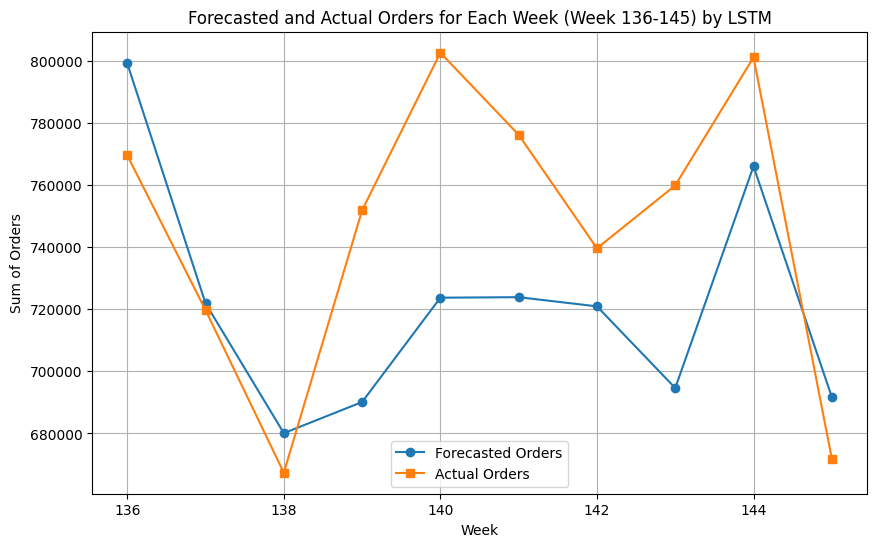

Mean Absolute Error: 48.96322247820832
Mean Squared Error: 7177.1231191723655
Root Mean Squared Error: 84.71790317974333
Mean Absolute Percentage Error: 36.3183209662036
R-squared: 0.9061863765882194


In [ ]:
# LSTM 3 layers(256,128,64) epochs=200 batch size= 256 ==> MAE=48.96
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Your data preprocessing code
lag_range = range(10, 15)
df_lag = df.copy()

lag_range = range(10, 15)

df_lag = df.copy()

for lag in lag_range:
    span = lag
    ewma_column = f'num_orders_ewma_{lag}'
    df_lag[ewma_column] = df['num_orders'].ewm(span=span, adjust=False).mean()

# Label encode categorical columns
label_encoder = LabelEncoder()
for col in ['category', 'cuisine', 'center_type']:
    df_lag[col] = label_encoder.fit_transform(df_lag[col])

X = df_lag.drop(['num_orders'], axis=1)
y = df_lag['num_orders']

# data splitting

train_data = df_lag[df_lag['week'] <= 135]
test_data = df_lag[(df_lag['week'] > 135) & (df_lag['week'] <= 145)]

X_train = train_data.drop(['num_orders'], axis=1)
y_train = train_data['num_orders']
X_test = test_data.drop(['num_orders'], axis=1)
y_test = test_data['num_orders']


# Create an instance of StandardScaler
scaler = StandardScaler()

# Apply standard scaling to your training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))



# Build the LSTM model
model = Sequential([
    LSTM(256, activation='tanh', return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.3),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mae')
model.fit(X_train_rnn, y_train, epochs=200, batch_size=256, verbose=1)

# Make predictions
predictions = model.predict(X_test_rnn).flatten()

# Create results dataframe
results_df = pd.DataFrame({
    'week': test_data['week'],
    'Actual': y_test,
    'Forecasted': predictions
})

print(results_df)
# Visualization
num_rows = results_df.shape[0]
print("Number of rows in results_df:", num_rows)

aggregated_results_df = results_df.groupby('week')['Forecasted'].sum().reset_index()
actual_sum = results_df.groupby('week')['Actual'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(aggregated_results_df['week'], aggregated_results_df['Forecasted'], marker='o', label='Forecasted Orders')
plt.plot(actual_sum['week'], actual_sum['Actual'], marker='s', label='Actual Orders')
plt.xlabel('Week')
plt.ylabel('Sum of Orders')
plt.title('Forecasted and Actual Orders for Each Week (Week 136-145) by LSTM')
plt.legend()
plt.grid()
plt.show()

# Evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
r_squared = 1 - (mse / np.var(y_test))

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r_squared)

# **Data Preparations **

In [48]:
df_lag = df.copy()
window_size = 10
# Create lag features for 'number_of_orders'
for lag in range(1, window_size + 1):
    span = lag
    ewma_column = f'lag_week{lag}'
    df_lag[ewma_column] = df['num_orders'].ewm(span=span, adjust=False).mean()
print(df_lag.head())

        id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1018704     2         55     1885          135.83      152.29   
2  1196273     3         55     1885          132.92      133.92   
3  1116527     4         55     1885          135.86      134.86   
4  1343872     5         55     1885          146.50      147.50   

   emailer_for_promotion  homepage_featured  num_orders   category  ...  \
0                      0                  0         177  Beverages  ...   
1                      0                  0         323  Beverages  ...   
2                      0                  0          96  Beverages  ...   
3                      0                  0         163  Beverages  ...   
4                      0                  0         215  Beverages  ...   

  lag_week1   lag_week2  lag_week3 lag_week4   lag_week5   lag_week6  \
0     177.0  177.000000      177.0  177.0000  177.000000  177.000000

In [ ]:
# Feature selection
features = df_lag [['week', 'num_orders','base_price','base_price',
            'lag_week1', 'lag_week2', 'lag_week3', 'lag_week4','lag_week5',
                   'lag_week6','lag_week7','lag_week8','lag_week9','lag_week10']]
target = 'num_orders'


In [ ]:

# Define the training, validation, and testing data
train_data = features[features['week'].between(1, 125)]  # Weeks 1-125 for training
validation_data = features[features['week'].between(126, 135)]  # Weeks 126-135 for validation
test_data = features[features['week'].between(136, 145)]  # Weeks 136-145 for testing

X_train = train_data.drop(['num_orders'], axis=1)
y_train = train_data['num_orders']
X_validation = validation_data.drop(['num_orders'], axis=1)
y_validation = validation_data['num_orders']
X_test = test_data.drop(['num_orders'], axis=1)
y_test = test_data['num_orders']

print("train_data: ", train_data.shape)
print('validation data:',validation_data.shape)
print("test_data: ", test_data.shape)

train_data:  (390907, 14)
validation data: (32820, 14)
test_data:  (32821, 14)


In [21]:
# Apply standard scaling to training , validation and test data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

# **Machine Learning Models **
in this part we will use two different machine lraning regressors
1- Random forest Regressor based on time series analysis
2- XGBoost regressor based on time series analysis

# First model is **Random Forest Regressor**

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=150, max_depth=9, max_features='sqrt', min_samples_split=2, min_samples_leaf=3)

# Train the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Use the model to predict on the validation data
val_predictions = rf_model.predict(X_validation_scaled)

# Calculate MAE on the validation data
val_mae = mean_absolute_error(y_validation, val_predictions)

# Use the model to predict on the test data
test_predictions = rf_model.predict(X_test_scaled)

# Calculate MAE on the test data
test_mae = mean_absolute_error(y_test, test_predictions)

print("Validation MAE:", val_mae)
print("Test MAE:", test_mae)


Validation MAE: 11.01419108527601
Test MAE: 8.16592473780128


In [19]:
# Create a DataFrame to store actual and forecasted values
results_df = pd.DataFrame({
    'week': test_data['week'],
    'Actual': y_test,
    'Forecasted': test_predictions
})
print(results_df)

        week  Actual  Forecasted
135      136     134  140.855258
136      137      96   99.338343
137      138      81   80.566054
138      139      67   66.330425
139      140     204  186.362668
...      ...     ...         ...
456543   141      13   40.790309
456544   142      42   42.430076
456545   143      40   38.576904
456546   144      53   48.505602
456547   145      27   25.463530

[32821 rows x 3 columns]


Number of rows in results_df: 32821


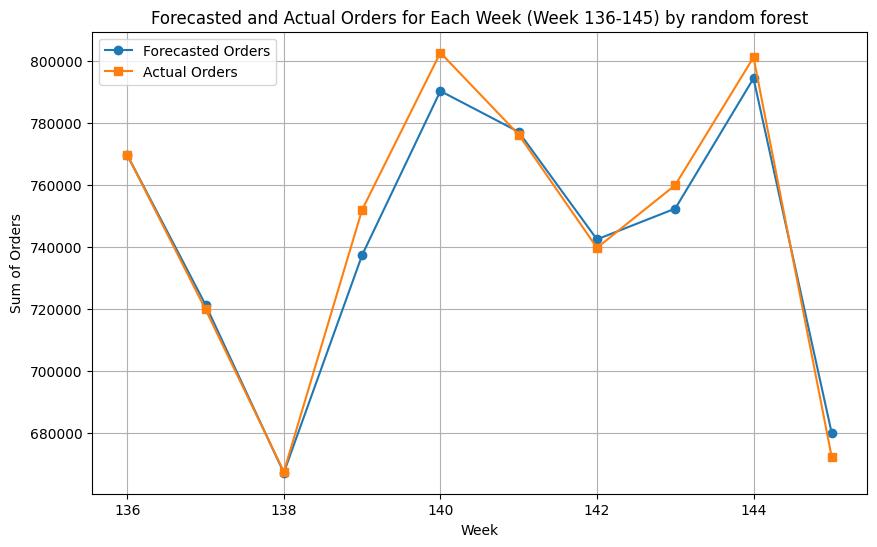

In [20]:
# Visualization for comparing actula orders and forecasted orders
num_rows = results_df.shape[0]
print("Number of rows in results_df:", num_rows)

aggregated_results_df = results_df.groupby('week')['Forecasted'].sum().reset_index()
actual_sum = results_df.groupby('week')['Actual'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(aggregated_results_df['week'], aggregated_results_df['Forecasted'], marker='o', label='Forecasted Orders')
plt.plot(actual_sum['week'], actual_sum['Actual'], marker='s', label='Actual Orders')
plt.xlabel('Week')
plt.ylabel('Sum of Orders')
plt.title('Forecasted and Actual Orders for Each Week (Week 136-145) by random forest')
plt.legend()
plt.grid()
plt.show()

In [22]:
# Evaluation
mae = mean_absolute_error(y_test, test_predictions )
mse = mean_squared_error(y_test, test_predictions )
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test-test_predictions) / y_test)) * 100
r_squared = 1 - (mse / np.var(y_test))

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r_squared)

Mean Absolute Error: 8.16592473780128
Mean Squared Error: 231.12144699015067
Root Mean Squared Error: 15.20267894123107
Mean Absolute Percentage Error: 6.7978954433144905
R-squared: 0.996978964965447


# DEEP LEARNING

# **In this part we will create 3 differenet Deep Learning Models and then compare all of them **
step 1: is creating lag features, in this step we create 10 lag features
step 2: is feature selection, in this step we select 14 features that are related with our regression problem
step 3: is splitting data, in this part we split data to 3 parts.
training data includes 125 weeks history.
validation data includes weeks from 126 to 135.
test data: includes 10 past weeks to predict the number of orders.
step 4: is applying normalization to training and test dataset
step 5: is building models, which we have 3 different models in this part



In [16]:
# Apply standard scaling to training , validation and test data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

In [23]:
# # Reshaping using NumPy reshape (time steps= 1)
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_validation_scaled_rnn = X_validation_scaled.reshape((X_validation_scaled.shape[0], 1, X_validation_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))



# First model is **Simple RNN**

In [ ]:
model = Sequential([
    SimpleRNN(256, activation='tanh', return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.3),
    SimpleRNN(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mae')
history = model.fit(X_train_rnn, y_train, epochs=25, batch_size=256, verbose=1, validation_data=(X_test_rnn, y_test))


Epoch 1/25
1527/1527 [==============================] - 42s 23ms/step - loss: 226.6150 - val_loss: 174.2737
Epoch 2/25
1527/1527 [==============================] - 30s 20ms/step - loss: 207.3658 - val_loss: 168.7779
Epoch 3/25
1527/1527 [==============================] - 33s 22ms/step - loss: 204.9749 - val_loss: 168.6930
Epoch 4/25
1527/1527 [==============================] - 43s 28ms/step - loss: 194.9906 - val_loss: 113.4200
Epoch 5/25
1527/1527 [==============================] - 47s 31ms/step - loss: 132.9474 - val_loss: 80.4958
Epoch 6/25
1527/1527 [==============================] - 41s 27ms/step - loss: 109.9371 - val_loss: 64.4180
Epoch 7/25
1527/1527 [==============================] - 47s 31ms/step - loss: 96.1994 - val_loss: 50.8613
Epoch 8/25
1527/1527 [==============================] - 33s 22ms/step - loss: 86.4408 - val_loss: 43.2881
Epoch 9/25
1527/1527 [==============================] - 39s 26ms/step - loss: 78.6648 - val_loss: 36.7725
Epoch 10/25
1527/1527 [=============

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_17 (SimpleRNN)   (None, 1, 256)            69120     
                                                                 
 dropout_17 (Dropout)        (None, 1, 256)            0         
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 1, 128)            49280     
                                                                 
 dropout_18 (Dropout)        (None, 1, 128)            0         
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 64)                12352     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

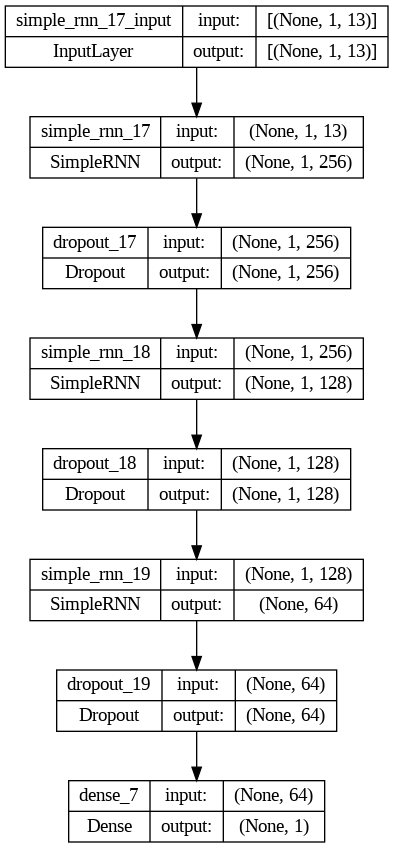

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

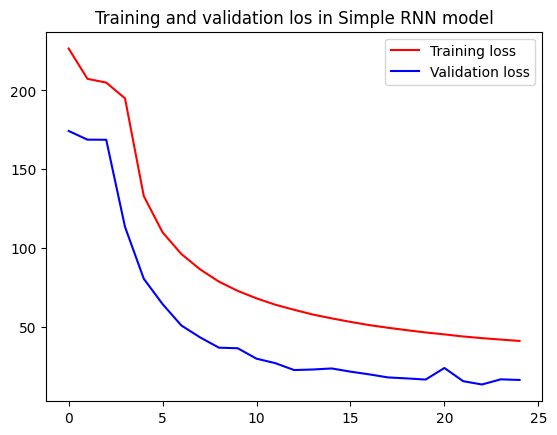

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation los in Simple RNN model')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# Make predictions
predictions = model.predict(X_test_rnn).flatten()

1026/1026 [==============================] - 7s 7ms/step


In [ ]:
results_df = pd.DataFrame({
    'week': test_data['week'],
    'Actual': y_test,
    'Forecasted': predictions
})

print(results_df)

        week  Actual  Forecasted
135      136     134  135.657440
136      137      96   97.681374
137      138      81   82.737892
138      139      67   69.018272
139      140     204  204.017822
...      ...     ...         ...
456543   141      13   18.405603
456544   142      42   45.513409
456545   143      40   43.913937
456546   144      53   56.533154
456547   145      27   31.935558

[32821 rows x 3 columns]


Number of rows in results_df: 32821


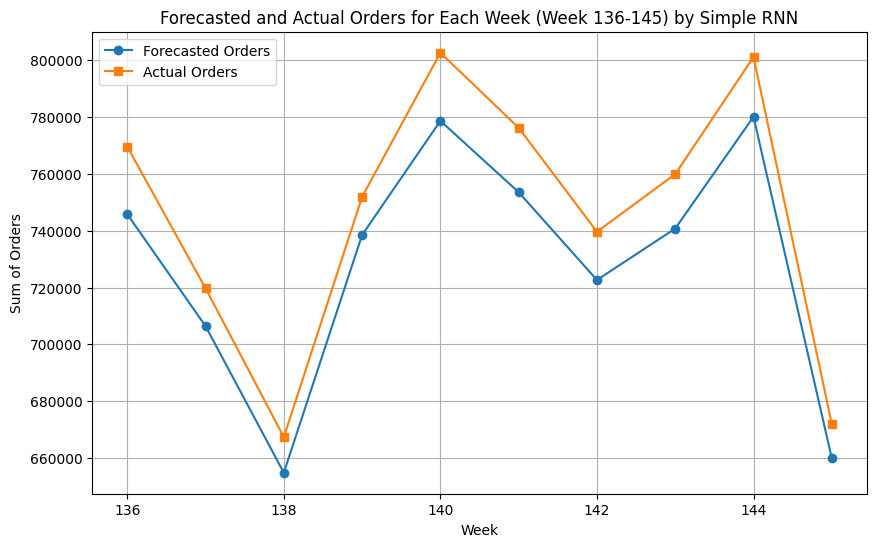

In [ ]:
# Visualization for comparing actula orders and forecasted orders
num_rows = results_df.shape[0]
print("Number of rows in results_df:", num_rows)

aggregated_results_df = results_df.groupby('week')['Forecasted'].sum().reset_index()
actual_sum = results_df.groupby('week')['Actual'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(aggregated_results_df['week'], aggregated_results_df['Forecasted'], marker='o', label='Forecasted Orders')
plt.plot(actual_sum['week'], actual_sum['Actual'], marker='s', label='Actual Orders')
plt.xlabel('Week')
plt.ylabel('Sum of Orders')
plt.title('Forecasted and Actual Orders for Each Week (Week 136-145) by Simple RNN')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Evaluation
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
r_squared = 1 - (mse / np.var(y_test))

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r_squared)

Mean Absolute Error: 16.29586249951496
Mean Squared Error: 4269.392254834848
Root Mean Squared Error: 65.34058658165573
Mean Absolute Percentage Error: 6.718116175194126
R-squared: 0.9441939130008353


In [26]:
results_df = pd.DataFrame({
    'week': test_data['week'],
    'Actual': y_test,
    'Forecasted': predictions
})

print(results_df)

        week  Actual  Forecasted
135      136     134  135.657440
136      137      96   97.681374
137      138      81   82.737892
138      139      67   69.018272
139      140     204  204.017822
...      ...     ...         ...
456543   141      13   18.405603
456544   142      42   45.513409
456545   143      40   43.913937
456546   144      53   56.533154
456547   145      27   31.935558

[32821 rows x 3 columns]


# Second Model is **LSTM**  time step = 1 week (7days)

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(256, activation='tanh', return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.3),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mae')
history = model.fit(X_train_rnn, y_train, epochs=50, batch_size=256, verbose=1, validation_data=(X_test_rnn, y_test))


Epoch 1/50
1527/1527 [==============================] - 66s 39ms/step - loss: 230.3760 - val_loss: 177.8903
Epoch 2/50
1527/1527 [==============================] - 60s 40ms/step - loss: 209.6692 - val_loss: 169.5903
Epoch 3/50
1527/1527 [==============================] - 59s 39ms/step - loss: 205.3719 - val_loss: 168.6564
Epoch 4/50
1527/1527 [==============================] - 59s 39ms/step - loss: 174.9980 - val_loss: 105.0937
Epoch 5/50
1527/1527 [==============================] - 59s 38ms/step - loss: 128.1167 - val_loss: 81.0962
Epoch 6/50
1527/1527 [==============================] - 58s 38ms/step - loss: 107.8992 - val_loss: 64.5067
Epoch 7/50
1527/1527 [==============================] - 58s 38ms/step - loss: 94.0884 - val_loss: 53.6825
Epoch 8/50
1527/1527 [==============================] - 56s 37ms/step - loss: 83.3778 - val_loss: 43.8841
Epoch 9/50
1527/1527 [==============================] - 57s 37ms/step - loss: 74.7782 - val_loss: 36.6167
Epoch 10/50
1527/1527 [=============

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            276480    
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            197120    
                                                                 
 dropout_21 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

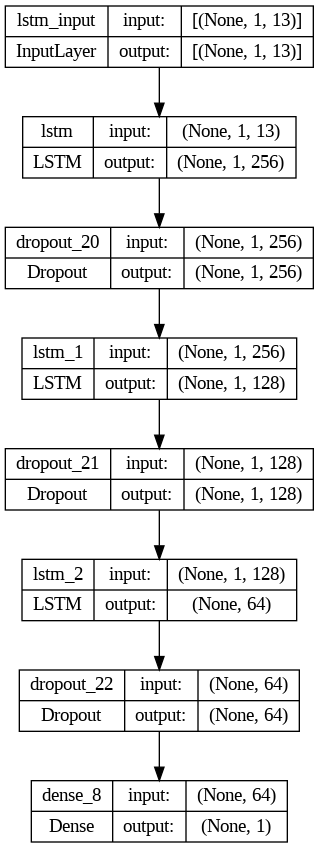

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

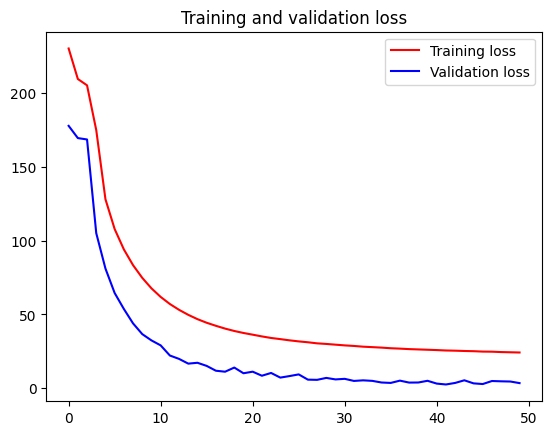

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# Make predictions
predictions = model.predict(X_test_rnn).flatten()

1026/1026 [==============================] - 5s 4ms/step


In [ ]:
# Create results dataframe
results_df = pd.DataFrame({
    'week': test_data['week'],
    'Actual': y_test,
    'Forecasted': predictions
})

print(results_df)

        week  Actual  Forecasted
135      136     134  133.665787
136      137      96   95.711891
137      138      81   80.738022
138      139      67   66.867958
139      140     204  203.453369
...      ...     ...         ...
456543   141      13   13.858862
456544   142      42   42.561592
456545   143      40   40.924370
456546   144      53   53.858498
456547   145      27   28.496155

[32821 rows x 3 columns]


Number of rows in results_df: 32821


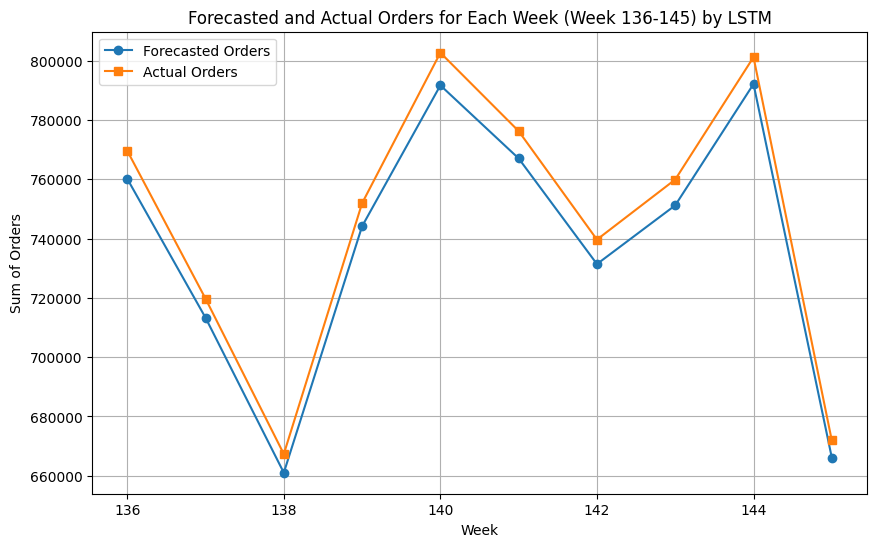

In [ ]:
# Visualization for comparing actula orders and forecasted orders
num_rows = results_df.shape[0]
print("Number of rows in results_df:", num_rows)

aggregated_results_df = results_df.groupby('week')['Forecasted'].sum().reset_index()
actual_sum = results_df.groupby('week')['Actual'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(aggregated_results_df['week'], aggregated_results_df['Forecasted'], marker='o', label='Forecasted Orders')
plt.plot(actual_sum['week'], actual_sum['Actual'], marker='s', label='Actual Orders')
plt.xlabel('Week')
plt.ylabel('Sum of Orders')
plt.title('Forecasted and Actual Orders for Each Week (Week 136-145) by LSTM')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
r_squared = 1 - (mse / np.var(y_test))

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r_squared)

Mean Absolute Error: 3.3850090238621666
Mean Squared Error: 336.70822228057995
Root Mean Squared Error: 18.34961095719961
Mean Absolute Percentage Error: 1.8750052701102722
R-squared: 0.9955988189361975


# In order to reshape our original 2D data into 3D “sliding window” , we will create the following codes **to reshape the data into sequences of length num_timestep**

In [37]:
num_timesteps = 4

# Reshape X_train to sequences of length (4 weeks= 1month)

X_train_rnn = []
for i in range(len(X_train_scaled) - num_timesteps + 1):
    X_train_rnn.append(X_train_scaled[i:i+num_timesteps])
X_train_rnn = np.array(X_train_rnn)

# Reshape X_validation to sequences of length num_timesteps
X_validation_rnn = []
y_validation_rnn = []
for i in range(len(X_validation_scaled) - num_timesteps + 1):
    X_validation_rnn.append(X_validation_scaled[i:i+num_timesteps])
X_validation_rnn = np.array(X_validation_rnn)

# Reshape X_test to sequences of length num_timesteps
X_test_rnn = []
y_test_rnn = []
for i in range(len(X_test_scaled)):
    if i + num_timesteps <= len(X_test_scaled):
        X_seq = X_test_scaled[i:i + num_timesteps]
    else:
        # Pad the incomplete sequence with zeros
        shortened_test_data = test_data.iloc[num_timesteps:]

    y_val = y_test.values[i]

    X_test_rnn.append(X_seq)
    y_test_rnn.append(y_val)

# Convert to arrays
X_test_rnn = np.array(X_test_rnn)
y_test_rnn = np.array(y_test_rnn)

y_train_aligned = y_train[num_timesteps - 1:]
y_val_aligned = y_validation[num_timesteps - 1:]

In [38]:
# Build the LSTM model
model = Sequential([
    LSTM(256, activation='tanh', return_sequences=True, input_shape=(num_timesteps, X_train.shape[1])),
    Dropout(0.2),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

In [39]:
model.compile(optimizer='adam', loss='mae')

model.fit(X_train_rnn, y_train_aligned, epochs=300, batch_size=256, verbose=1,validation_data=(X_validation_rnn, y_val_aligned) )

Epoch 1/300
1527/1527 [==============================] - 19s 9ms/step - loss: 226.4758 - val_loss: 209.7543
Epoch 2/300
1527/1527 [==============================] - 12s 8ms/step - loss: 207.1855 - val_loss: 203.1147
Epoch 3/300
1527/1527 [==============================] - 12s 8ms/step - loss: 185.2291 - val_loss: 146.6385
Epoch 4/300
1527/1527 [==============================] - 12s 8ms/step - loss: 126.0957 - val_loss: 114.4415
Epoch 5/300
1527/1527 [==============================] - 12s 8ms/step - loss: 102.4930 - val_loss: 97.2591
Epoch 6/300
1527/1527 [==============================] - 12s 8ms/step - loss: 87.0090 - val_loss: 84.4501
Epoch 7/300
1527/1527 [==============================] - 11s 7ms/step - loss: 75.5172 - val_loss: 77.1608
Epoch 8/300
1527/1527 [==============================] - 12s 8ms/step - loss: 66.4828 - val_loss: 68.6557
Epoch 9/300
1527/1527 [==============================] - 12s 8ms/step - loss: 59.4037 - val_loss: 62.6602
Epoch 10/300
1527/1527 [=============

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4, 256)            276480    
                                                                 
 dropout_12 (Dropout)        (None, 4, 256)            0         
                                                                 
 lstm_13 (LSTM)              (None, 4, 128)            197120    
                                                                 
 dropout_13 (Dropout)        (None, 4, 128)            0         
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

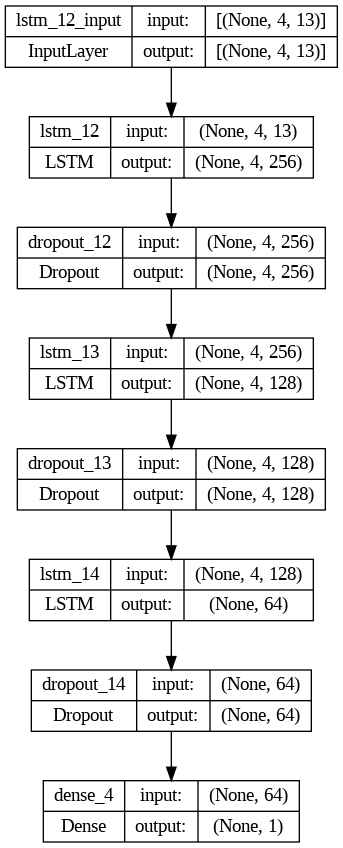

In [41]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

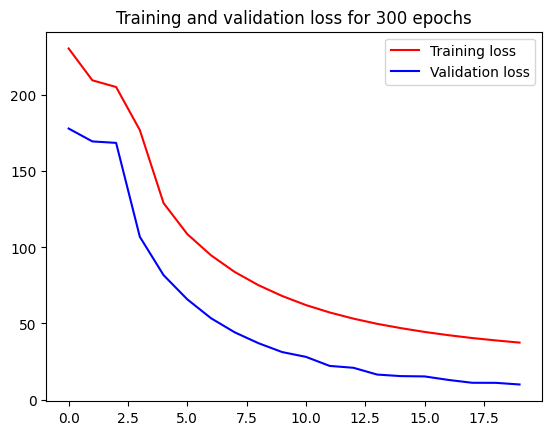

<Figure size 640x480 with 0 Axes>

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for 300 epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [44]:
# Make predictions
predictions = model.predict(X_test_rnn).flatten()

1026/1026 [==============================] - 6s 4ms/step


In [45]:
# Create results dataframe
results_df = pd.DataFrame({
    'week': test_data['week'],
    'Actual': y_test,
    'Forecasted': predictions
})

print(results_df)

        week  Actual  Forecasted
135      136     134   66.243507
136      137      96  204.865967
137      138      81  105.587845
138      139      67  121.372452
139      140     204  174.729858
...      ...     ...         ...
456543   141      13   53.057381
456544   142      42   28.653671
456545   143      40   28.653671
456546   144      53   28.653671
456547   145      27   28.653671

[32821 rows x 3 columns]


Number of rows in results_df: 32821


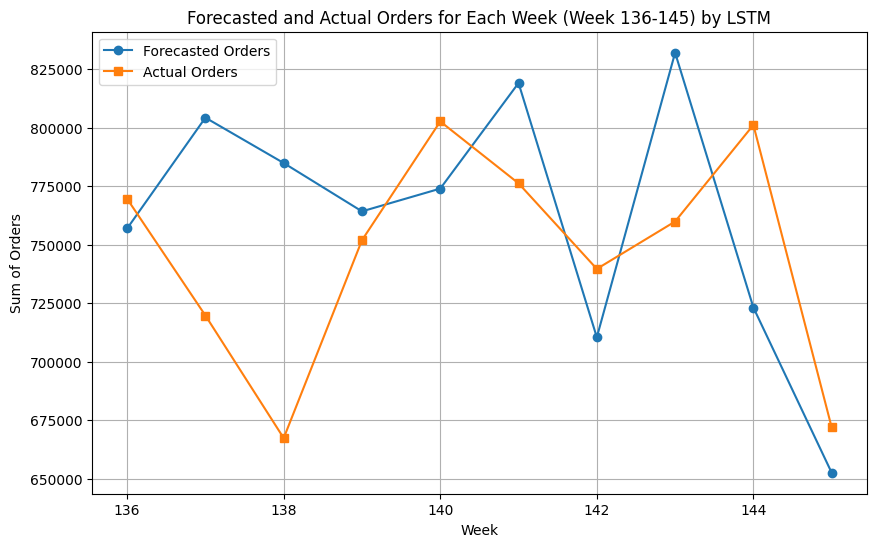

In [46]:
# Visualization for comparing actula orders and forecasted orders
num_rows = results_df.shape[0]
print("Number of rows in results_df:", num_rows)

aggregated_results_df = results_df.groupby('week')['Forecasted'].sum().reset_index()
actual_sum = results_df.groupby('week')['Actual'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(aggregated_results_df['week'], aggregated_results_df['Forecasted'], marker='o', label='Forecasted Orders')
plt.plot(actual_sum['week'], actual_sum['Actual'], marker='s', label='Actual Orders')
plt.xlabel('Week')
plt.ylabel('Sum of Orders')
plt.title('Forecasted and Actual Orders for Each Week (Week 136-145) by LSTM')
plt.legend()
plt.grid()
plt.show()

In [47]:
# Evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
r_squared = 1 - (mse / np.var(y_test))

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r_squared)

Mean Absolute Error: 129.03432986832257
Mean Squared Error: 54964.79759315818
Root Mean Squared Error: 234.44572419465914
Mean Absolute Percentage Error: 130.72500420766085
R-squared: 0.28154404812496703
